<a href="https://colab.research.google.com/github/jacobgreen4477/The-4th-ETRI-AI-Human-Understanding-Competition/blob/main/dacon_etri_lifelog_model_vF1_0_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

> title : 제 4회 ETRI 휴먼이해 인공지능 논문경진대회 <br>
> author : hjy,byc <br>

### 📦 라이브러리

In [1]:
! pip install haversine >/dev/null
! pip install optuna  >/dev/null
! pip install category_encoders >/dev/null
! pip install tabpfn  >/dev/null
! pip install catboost >/dev/null
! pip install torchmetrics >/dev/null

In [2]:
# 기본 모듈
import os
import sys
import re
import ast
import glob
import random
import warnings
from collections import Counter
from math import radians, cos, sin, asin, sqrt
from functools import reduce
from datetime import datetime, timedelta, time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 머신러닝
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, cross_val_score
from sklearn.metrics import f1_score, roc_auc_score, roc_curve
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.utils.class_weight import compute_class_weight, compute_sample_weight
from category_encoders import TargetEncoder
from lightgbm import LGBMClassifier, log_evaluation, early_stopping
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
import lightgbm as lgb
from tabpfn import TabPFNClassifier

# PyTorch
import torch
from torch import nn
from torch.nn import functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

# Hugging Face
from huggingface_hub import login
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    LlamaTokenizer,
    LlamaForCausalLM,
    LlamaForSequenceClassification
)

# PEFT (Parameter-Efficient Fine-Tuning)
from peft import (
    LoraConfig,
    get_peft_model,
    get_peft_model_state_dict,
    TaskType
)

# Evaluation & Utilities
from torchmetrics import Accuracy

# 기타
from tqdm import tqdm
from tqdm.auto import tqdm as auto_tqdm  # 필요 시 구분
from scipy.stats import entropy
from haversine import haversine
from io import StringIO
import gc

# wandb
import wandb
wandb.login(key="5fa8dfb2c5be3c888bfe0101437a8fa22fbdf0e0")
wandb.init(project="etri_lifelog", entity="byc3230")

# 옵션
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ["TOKENIZERS_PARALLELISM"] = "false"
pd.set_option('display.max_columns', 999)
pd.set_option('display.max_rows', 999)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.float_format', lambda x: '%0.4f' % x)

# 기타
warnings.filterwarnings('ignore')

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: byc3230 to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [3]:
string = """
subject_id,sleep_date
id01,2024-07-24
id01,2024-08-26
id01,2024-08-28
id01,2024-08-29
id02,2024-08-23
id02,2024-09-24
id02,2024-09-26
id02,2024-09-27
id03,2024-08-30
id03,2024-09-01
id03,2024-09-02
id03,2024-09-06
id04,2024-09-03
id04,2024-10-10
id04,2024-10-12
id04,2024-10-13
id05,2024-10-19
id05,2024-10-23
id05,2024-10-24
id05,2024-10-27
id06,2024-07-25
id06,2024-07-26
id06,2024-07-27
id06,2024-07-30
id07,2024-07-07
id07,2024-08-02
id07,2024-08-04
id07,2024-08-05
id08,2024-08-28
id08,2024-08-29
id08,2024-08-30
id08,2024-09-02
id09,2024-08-02
id09,2024-08-31
id09,2024-09-02
id09,2024-09-03
id10,2024-08-28
id10,2024-08-30
id10,2024-08-31
id10,2024-09-03
"""

# DataFrame 생성
valid_ids = pd.read_csv(StringIO(string), sep=',')
valid_ids['pk'] = valid_ids['subject_id']+valid_ids['sleep_date']

In [4]:
string = """
subject_id	sleep_date
id01	2024-07-24
id01	2024-07-27
id01	2024-08-18
id01	2024-08-19
id01	2024-08-20
id01	2024-08-21
id01	2024-08-22
id01	2024-08-24
id01	2024-08-25
id01	2024-08-26
id01	2024-08-27
id01	2024-08-28
id01	2024-08-29
id01	2024-08-30
id02	2024-08-23
id02	2024-08-24
id02	2024-09-16
id02	2024-09-17
id02	2024-09-19
id02	2024-09-20
id02	2024-09-21
id02	2024-09-22
id02	2024-09-23
id02	2024-09-24
id02	2024-09-25
id02	2024-09-26
id02	2024-09-27
id02	2024-09-28
id03	2024-08-30
id03	2024-09-01
id03	2024-09-02
id03	2024-09-03
id03	2024-09-05
id03	2024-09-06
id03	2024-09-07
id04	2024-09-03
id04	2024-09-04
id04	2024-09-05
id04	2024-09-06
id04	2024-09-07
id04	2024-09-08
id04	2024-09-09
id04	2024-10-08
id04	2024-10-09
id04	2024-10-10
id04	2024-10-11
id04	2024-10-12
id04	2024-10-13
id04	2024-10-14
id05	2024-10-19
id05	2024-10-23
id05	2024-10-24
id05	2024-10-25
id05	2024-10-26
id05	2024-10-27
id05	2024-10-28
id06	2024-07-25
id06	2024-07-26
id06	2024-07-27
id06	2024-07-28
id06	2024-07-29
id06	2024-07-30
id06	2024-07-31
id07	2024-07-07
id07	2024-07-08
id07	2024-07-09
id07	2024-07-10
id07	2024-07-11
id07	2024-07-12
id07	2024-07-13
id07	2024-07-30
id07	2024-08-01
id07	2024-08-02
id07	2024-08-03
id07	2024-08-04
id07	2024-08-05
id07	2024-08-06
id08	2024-08-28
id08	2024-08-29
id08	2024-08-30
id08	2024-08-31
id08	2024-09-01
id08	2024-09-02
id08	2024-09-04
id09	2024-08-02
id09	2024-08-22
id09	2024-08-23
id09	2024-08-24
id09	2024-08-25
id09	2024-08-27
id09	2024-08-28
id09	2024-08-29
id09	2024-08-30
id09	2024-08-31
id09	2024-09-01
id09	2024-09-02
id09	2024-09-03
id09	2024-09-04
id10	2024-08-28
id10	2024-08-30
id10	2024-08-31
id10	2024-09-01
id10	2024-09-02
id10	2024-09-03
id10	2024-09-06
"""

# DataFrame 생성
valid_ids2 = pd.read_csv(StringIO(string), sep='\t')
valid_ids2['pk'] = valid_ids2['subject_id']+valid_ids2['sleep_date']

### 📦 데이터 읽기

In [5]:
from google.colab import drive, files
drive.mount('/content/drive')

path = '/content/drive/MyDrive/data/ch2025_data_items/share/'

# [1]공통
train = pd.read_parquet(f'{path}train_63775_v2.parquet')
test = pd.read_parquet(f'{path}test_63775_v2.parquet')

# [2]version2 train,test 데이터셋 by 현종열
# train = pd.read_parquet(f'{path}train_hjy_0603_v1.parquet')
# test = pd.read_parquet(f'{path}test_hjy_0603_v1.parquet')

# [3]QWEN3 8B 활용한 결측처리 (대상: mScreenStatus)
mScreenStatus_llm = pd.read_excel(f'{path}mScreenStatus_llm결측값생성후파생변수생성_20250609_v1.xlsx')

# mScreenStatus_llm 컬럼 추가
feats = ['sleep_time', 'wake_time', 'sleep_duration_min', 'avg_sleep_time', 'avg_wake_time', 'avg_sleep_duration', 'sleep_time_diff', 'wake_time_diff', 'sleep_duration_diff', 'sleep_time_ratio', 'wake_time_ratio', 'sleep_duration_ratio', 'sleep_time_lag1', 'wake_time_lag1', 'sleep_duration_lag1', 'sleep_time_diff_lag1', 'wake_time_diff_lag1', 'sleep_duration_diff_lag1', 'sleep_time_ratio_lag1', 'wake_time_ratio_lag1', 'sleep_duration_ratio_lag1', 'sleep_time_lag2', 'wake_time_lag2', 'sleep_duration_lag2', 'sleep_time_diff_lag2', 'wake_time_diff_lag2', 'sleep_duration_diff_lag2', 'sleep_time_ratio_lag2', 'wake_time_ratio_lag2', 'sleep_duration_ratio_lag2', 'sleep_time_mean2d', 'wake_time_mean2d', 'sleep_duration_min_mean2d', 'sleep_time_diff_mean2d', 'wake_time_diff_mean2d', 'sleep_duration_diff_mean2d', 'sleep_time_ratio_mean2d', 'wake_time_ratio_mean2d', 'sleep_duration_ratio_mean2d', 'sleep_time_std2d', 'wake_time_std2d', 'sleep_duration_min_std2d', 'sleep_time_diff_std2d', 'wake_time_diff_std2d', 'sleep_duration_diff_std2d', 'sleep_time_ratio_std2d', 'wake_time_ratio_std2d', 'sleep_duration_ratio_std2d', 'sleep_time_mean3d', 'wake_time_mean3d', 'sleep_duration_min_mean3d', 'sleep_time_diff_mean3d', 'wake_time_diff_mean3d', 'sleep_duration_diff_mean3d', 'sleep_time_ratio_mean3d', 'wake_time_ratio_mean3d', 'sleep_duration_ratio_mean3d', 'sleep_time_std3d', 'wake_time_std3d', 'sleep_duration_min_std3d', 'sleep_time_diff_std3d', 'wake_time_diff_std3d', 'sleep_duration_diff_std3d', 'sleep_time_ratio_std3d', 'wake_time_ratio_std3d', 'sleep_duration_ratio_std3d', 'sleep_time_mean5d', 'wake_time_mean5d', 'sleep_duration_min_mean5d', 'sleep_time_diff_mean5d', 'wake_time_diff_mean5d', 'sleep_duration_diff_mean5d', 'sleep_time_ratio_mean5d', 'wake_time_ratio_mean5d', 'sleep_duration_ratio_mean5d', 'sleep_time_std5d', 'wake_time_std5d', 'sleep_duration_min_std5d', 'sleep_time_diff_std5d', 'wake_time_diff_std5d', 'sleep_duration_diff_std5d', 'sleep_time_ratio_std5d', 'wake_time_ratio_std5d', 'sleep_duration_ratio_std5d', 'sleep_time_mean7d', 'wake_time_mean7d', 'sleep_duration_min_mean7d', 'sleep_time_diff_mean7d', 'wake_time_diff_mean7d', 'sleep_duration_diff_mean7d', 'sleep_time_ratio_mean7d', 'wake_time_ratio_mean7d', 'sleep_duration_ratio_mean7d', 'sleep_time_std7d', 'wake_time_std7d', 'sleep_duration_min_std7d', 'sleep_time_diff_std7d', 'wake_time_diff_std7d', 'sleep_duration_diff_std7d', 'sleep_time_ratio_std7d', 'wake_time_ratio_std7d', 'sleep_duration_ratio_std7d', 'weekday_avg_sleep', 'sleep_duration_weekday_avg_diff', 'sleep_duration_weekday_avg_div']
drop_features = [i for i in feats if i in train.columns]
train = train.drop(columns=drop_features)
train = train.merge(mScreenStatus_llm,on=['subject_id','lifelog_date'],how='left')
test = test.drop(columns=drop_features)
test = test.merge(mScreenStatus_llm,on=['subject_id','lifelog_date'],how='left')

# check
print('# train  shape:',train.shape)
print('# test   shape:',test.shape)

Mounted at /content/drive
# train  shape: (450, 340)
# test   shape: (250, 340)


Baseline RMSE: 0.4847


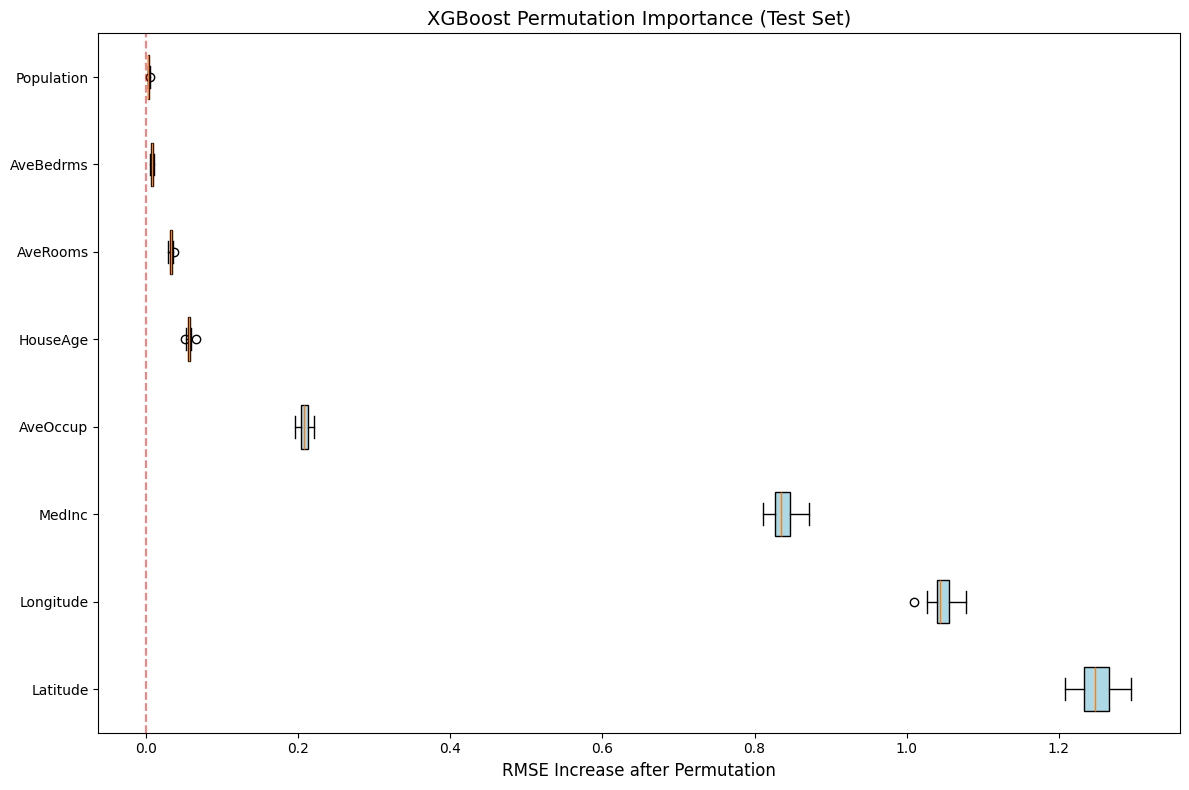


Top Features by Permutation Importance:
Latitude  : 1.2505 ± 0.0224
Longitude : 1.0471 ± 0.0156
MedInc    : 0.8363 ± 0.0131
AveOccup  : 0.2083 ± 0.0064
HouseAge  : 0.0569 ± 0.0024
AveRooms  : 0.0328 ± 0.0018
AveBedrms : 0.0080 ± 0.0011
Population: 0.0036 ± 0.0009


In [8]:
# 라이브러리 임포트
from sklearn.datasets import fetch_california_housing
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import numpy as np
import matplotlib.pyplot as plt

# 데이터 로드
data = fetch_california_housing()
X, y = data.data, data.target
feature_names = data.feature_names

# 훈련/테스트 세트 분할 (70:30)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

# XGBoost 모델 구성 및 훈련
model = xgb.XGBRegressor(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=5,
    random_state=42,
    eval_metric='rmse'
)
model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    #early_stopping_rounds=10,
    verbose=False
)

# 테스트 세트 성능 평가
pred = model.predict(X_test)
baseline_rmse = np.sqrt(mean_squared_error(y_test, pred))
print(f"Baseline RMSE: {baseline_rmse:.4f}")

# 순열 중요도 계산
result = permutation_importance(
    model,
    X_test,
    y_test,
    n_repeats=30,               # 안정적인 결과를 위해 30회 반복
    random_state=42,
    scoring='neg_mean_squared_error'  # MSE 기반
)

# 중요도 정렬 (평균 중요도 기준)
sorted_idx = result.importances_mean.argsort()[::-1]

# 시각화
plt.figure(figsize=(12, 8))
plt.boxplot(
    result.importances[sorted_idx].T,
    vert=False,
    labels=np.array(feature_names)[sorted_idx],
    patch_artist=True,
    boxprops=dict(facecolor='lightblue')
)
plt.axvline(x=0, color='red', linestyle='--', alpha=0.5)
plt.title("XGBoost Permutation Importance (Test Set)", fontsize=14)
plt.xlabel("RMSE Increase after Permutation", fontsize=12)
plt.tight_layout()
plt.show()

# 상위 N개 변수 출력
print("\nTop Features by Permutation Importance:")
for i in sorted_idx:
    if result.importances_mean[i] > 0:  # 양의 중요도만 선택
        imp_mean = result.importances_mean[i]
        imp_std = result.importances_std[i]
        print(f"{feature_names[i]:<10}: {imp_mean:.4f} ± {imp_std:.4f}")

In [23]:
vi_df = pd.DataFrame({
     '변수명':np.array(feature_names)[sorted_idx]
    ,'중요도':result.importances_mean[sorted_idx]
})

vi_df.loc[vi_df['중요도']>0,'변수명'].tolist()

['Latitude',
 'Longitude',
 'MedInc',
 'AveOccup',
 'HouseAge',
 'AveRooms',
 'AveBedrms',
 'Population']

### ============================

### run_basemodel

In [24]:
def run_basemodel(train, test, valid_ids, common_params, n_splits, n_top_features, random_state=42):

    lgb_A = 0.333
    xgb_B = 0.334
    tab_C = 0.333

    train_df = train.copy()
    test_df = test.copy()

    submission_final = test_df[['subject_id', 'sleep_date', 'lifelog_date']].copy()
    submission_final['lifelog_date'] = pd.to_datetime(submission_final['lifelog_date']).dt.date

    # 타겟
    targets_binary = ['Q1', 'Q2', 'Q3', 'S2', 'S3']
    targets_binary_name = ['기상직후수면질','취침전신체적피로','취침전스트레스','수면효율','수면잠들기시간']
    target_multiclass = 'S1'
    all_targets = targets_binary + [target_multiclass]

    # 노이즈 수준 설정
    def add_noise(series, noise_level, seed=3):
        rng = np.random.default_rng(seed)
        return series * (1 + noise_level * rng.standard_normal(len(series)))

    noise_level = 0.015  # 필요에 따라 조정

    # 타겟인코딩
    for tgt in all_targets:

      encoder_feats = ['subject_id','month','weekend'] # 'weekday', 'subject_id','month','weekend'

      #### 타겟인코딩1

      subject_mean = train_df.groupby(encoder_feats)[tgt].mean().rename(f'{tgt}_te')
      train_df = train_df.merge(subject_mean, on=encoder_feats, how='left')
      test_df = test_df.merge(subject_mean, on=encoder_feats, how='left')
      global_mean = train_df[tgt].mean()
      test_df[f'{tgt}_te'] = test_df[f'{tgt}_te'].fillna(global_mean)

      # 노이즈 추가
      train_df[f'{tgt}_te'] = add_noise(train_df[f'{tgt}_te'], noise_level)
      test_df[f'{tgt}_te'] = add_noise(test_df[f'{tgt}_te'], noise_level)

      #### 타겟인코딩2

      # 새로운 범주형 열 생성
      train_df['TMP'] = train_df[encoder_feats].applymap(str).apply(lambda x: ''.join(x) ,axis=1)
      test_df['TMP'] = test_df[encoder_feats].applymap(str).apply(lambda x: ''.join(x) ,axis=1)

      # 인코더
      encoder = TargetEncoder(cols=['TMP'], smoothing=300) # 40
      encoder.fit(train_df[['TMP']], train_df[tgt])

      # 인코딩 결과를 새로운 열에 저장
      train_df[f'{tgt}_te2'] = encoder.transform(train_df[['TMP']])
      test_df[f'{tgt}_te2'] = encoder.transform(test_df[['TMP']])

      # 노이즈 추가
      train_df[f'{tgt}_te2'] = add_noise(train_df[f'{tgt}_te2'], noise_level)
      test_df[f'{tgt}_te2'] = add_noise(test_df[f'{tgt}_te2'], noise_level)

      # 불필요한 변수 제거
      train_df = train_df.drop(columns=['TMP'])
      test_df = test_df.drop(columns=['TMP'])


    # 인코딩
    PK = ['sleep_date', 'lifelog_date', 'subject_id']
    encoder = LabelEncoder()
    categorical_features = [i for i in train_df.select_dtypes(include=['object', 'category']).columns if i not in PK+['pk']]
    for col in categorical_features:
        print(col)
        train_df[col] = encoder.fit_transform(train_df[col])
        test_df[col] = encoder.fit_transform(test_df[col])

    # X
    X = train_df.drop(columns=PK + all_targets)
    test_X = test_df.drop(columns=PK + all_targets)
    print(f'# X shape: {X.shape}')
    print(f'# test_X shape: {test_X.shape}')

    print('\n STEP1: 실험 결과 확인')
    print("=============== Validation Results ==============")
    total_avg_f1s = []
    val_f1 = []
    binary_val_preds = {}
    multiclass_val_preds = {}
    binary_test_preds = {}
    multiclass_test_preds = {}
    test_preds = {}

    # Find optimal weights
    best_weights = []
    best_scores = []

    for col in targets_binary:


        # binary
        y = train_df[col]

        valid_ids['pk'] = valid_ids['subject_id']+valid_ids['sleep_date']
        train_df['pk'] = train_df['subject_id']+train_df['sleep_date']

        X_valid = train_df.loc[train_df['pk'].isin(valid_ids['pk']),X.columns.tolist()].reset_index(drop=True).copy()
        X_train = train_df.loc[~train_df['pk'].isin(valid_ids['pk']),X.columns.tolist()].reset_index(drop=True).copy()
        y_valid = train_df.loc[train_df['pk'].isin(valid_ids['pk']),y.name].reset_index(drop=True).copy()
        y_train = train_df.loc[~train_df['pk'].isin(valid_ids['pk']),y.name].reset_index(drop=True).copy()

        # ---------------------------------------------------------------------------------

        from sklearn.inspection import permutation_importance

        feature_names = X.columns.tolist()

        xgb_params = {
            'n_estimators': 1000,
            'learning_rate': 0.01,
            'max_depth': 6,
            'min_child_weight': 1,
            'subsample': 0.8,
            'colsample_bytree': 0.8,
            'random_state': random_state
        }

        # Train XGBoost
        xgb_model = XGBClassifier(**xgb_params)
        xgb_model.fit(X_train, y_train)

        # 순열 중요도 계산
        result = permutation_importance(
            xgb_model,
            X_valid,
            y_valid,
            n_repeats=3,          # 안정적인 결과를 위해 30회 반복
            random_state=42,
            scoring='f1'
        )

        # 중요도 정렬 (평균 중요도 기준 내림차순)
        sorted_idx = result.importances_mean.argsort()[::-1]

        ### 상위 30개 변수만 선택 ###
        # n_top_features = 30  # 시각화할 변수 수
        top_indices = sorted_idx[:n_top_features]  # 상위 30개 인덱스

        # 시각화 (상위 30개만)
        plt.figure(figsize=(12, 10))  # 크기 조정

        # 박스플롯 생성
        boxplot = plt.boxplot(
            result.importances[top_indices].T,
            vert=False,
            labels=np.array(feature_names)[top_indices],
            patch_artist=True,
            boxprops=dict(facecolor='lightgreen', alpha=0.8),
            whiskerprops=dict(color='gray', linestyle='-'),
            medianprops=dict(color='red', linewidth=2)
        )

        # 중요도 0 기준선
        plt.axvline(x=0, color='blue', linestyle='--', alpha=0.7, linewidth=1.5)

        # 레이블 및 제목
        plt.title(f"Top {n_top_features} Features by Permutation Importance (F1-score)",
                  fontsize=16, pad=20)
        plt.xlabel("F1-score Decrease after Permutation", fontsize=12)
        plt.ylabel("Features", fontsize=12)

        # 그리드 추가
        plt.grid(axis='x', linestyle='--', alpha=0.4)

        # 변수명 가독성 향상
        plt.yticks(fontsize=10)
        plt.tight_layout()

        # 상위 30개 변수 중요도 값 출력
        print(f"\nTop {n_top_features} Features:")
        for i, idx in enumerate(top_indices):
            imp_mean = result.importances_mean[idx]
            imp_std = result.importances_std[idx]
            rank = i + 1
            print(f"#{rank:2d} {feature_names[idx]:<25}: {imp_mean:.4f} ± {imp_std:.4f}")

        plt.show()

        vi_df = pd.DataFrame({
            '변수명':np.array(feature_names)[sorted_idx]
            ,'중요도':result.importances_mean[sorted_idx]
        })

        xfeatures = vi_df.loc[vi_df['중요도']>0,'변수명'].tolist()

        # ---------------------------------------------------------------------------------

        X_valid = train_df.loc[train_df['pk'].isin(valid_ids['pk']),xfeatures].reset_index(drop=True).copy()
        X_train = train_df.loc[~train_df['pk'].isin(valid_ids['pk']),xfeatures].reset_index(drop=True).copy()
        y_valid = train_df.loc[train_df['pk'].isin(valid_ids['pk']),y.name].reset_index(drop=True).copy()
        y_train = train_df.loc[~train_df['pk'].isin(valid_ids['pk']),y.name].reset_index(drop=True).copy()

        # Get parameters for both models
        lgb_params = common_params[col].copy()
        lgb_params['random_state'] = random_state

        xgb_params = {
            'n_estimators': 1000,
            'learning_rate': 0.01,
            'max_depth': 6,
            'min_child_weight': 1,
            'subsample': 0.8,
            'colsample_bytree': 0.8,
            'random_state': random_state
        }

        # Train LightGBM
        lgb_model = LGBMClassifier(**lgb_params)
        lgb_model.fit(X_train, y_train)

        # Train XGBoost
        xgb_model = XGBClassifier(**xgb_params)
        xgb_model.fit(X_train, y_train)

        tabpfn_params = {
            'device': 'cuda'
        }

        # Train TabPFN
        tabpfn_model = TabPFNClassifier(**tabpfn_params)
        tabpfn_model.fit(X_train, y_train)
        tab_pred_valid = tabpfn_model.predict_proba(X_valid.values)[:, 1]

        lgb_pred_valid = lgb_model.predict_proba(X_valid)[:, 1]
        xgb_pred_valid = xgb_model.predict_proba(X_valid)[:, 1]

        pred_valid = (lgb_A * lgb_pred_valid + xgb_B * xgb_pred_valid + tab_C * tab_pred_valid > 0.5).astype(int)

        f1 = f1_score(y_valid, pred_valid, average='macro')
        val_f1.append(f1)

        # Store predictions
        binary_val_preds[col] = {
            'lgb': lgb_pred_valid,
            'xgb': xgb_pred_valid,
            'tab': tab_pred_valid,
            'true': y_valid
        }



    # multiclass
    y = train_df[target_multiclass]
    X_valid = train_df.loc[train_df['pk'].isin(valid_ids['pk']),X.columns.tolist()].reset_index(drop=True).copy()
    X_train = train_df.loc[~train_df['pk'].isin(valid_ids['pk']),X.columns.tolist()].reset_index(drop=True).copy()
    y_valid = train_df.loc[train_df['pk'].isin(valid_ids['pk']),y.name].reset_index(drop=True).copy()
    y_train = train_df.loc[~train_df['pk'].isin(valid_ids['pk']),y.name].reset_index(drop=True).copy()

    # Get parameters for both models
    lgb_params = common_params['S1'].copy()
    lgb_params['random_state'] = random_state

    xgb_params = {
        'n_estimators': 1000,
        'learning_rate': 0.01,
        'max_depth': 6,
        'min_child_weight': 1,
        'subsample': 0.8,
        'colsample_bytree': 0.8,
        'random_state': random_state
    }

    # 클래스 weight 계산
    classes = np.unique(y_train)
    weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
    class_weights = dict(zip(classes, weights))

    # 각 샘플에 대해 weight 매핑
    w_train = pd.Series(y_train).map(class_weights)
    w_train = compute_sample_weight(class_weight='balanced', y=y_train)

    # Train LightGBM
    lgb_model = LGBMClassifier(**lgb_params, objective='multiclass', num_class=3)
    lgb_model.fit(X_train, y_train, sample_weight=w_train)

    # Train XGBoost
    xgb_model = XGBClassifier(**xgb_params, objective='multi:softmax', num_class=3)
    xgb_model.fit(X_train, y_train,sample_weight=w_train)

    tabpfn_params = {
        'device': 'cuda'
    }

    # Train TabPFN
    tabpfn_model = TabPFNClassifier(**tabpfn_params)
    tabpfn_model.fit(X_train, y_train)

    # Get predictions and ensemble
    lgb_pred_valid = lgb_model.predict_proba(X_valid)
    xgb_pred_valid = xgb_model.predict_proba(X_valid)
    tab_pred_valid = tabpfn_model.predict_proba(X_valid.values)

    pred_valid = np.argmax(lgb_A * lgb_pred_valid + xgb_B * xgb_pred_valid + tab_C * tab_pred_valid, axis=1)

    f1 = f1_score(y_valid, pred_valid, average='macro')
    val_f1.append(f1)

    multiclass_val_preds = {
        'lgb': lgb_pred_valid,
        'xgb': xgb_pred_valid,
        'tab': tab_pred_valid,
        'true': y_valid
    }

    # Generate all possible weight combinations that sum to 1
    step = 0.1
    for lgb_A in np.arange(0, 1.1, step):
        for xgb_B in np.arange(0, 1.1 - lgb_A, step):
            for tab_C in np.arange(0, 1.1 - lgb_A - xgb_B, step):
                TOT = 1 - (lgb_A + xgb_B + tab_C)
                if TOT == 0:
                    weights = (lgb_A, xgb_B, tab_C)
                    val_scores = []

                    # Binary targets
                    for col in targets_binary:
                        preds = binary_val_preds[col]
                        ensemble_pred = (lgb_A * preds['lgb'] + xgb_B * preds['xgb'] + tab_C * preds['tab'] > 0.5).astype(int)
                        f1 = f1_score(preds['true'], ensemble_pred, average='macro')
                        val_scores.append(f1)
                        # print(f" Validation Score {col}:{f1:.4f}")

                    # Multiclass target
                    preds = multiclass_val_preds
                    ensemble_pred = np.argmax(lgb_A * preds['lgb'] + xgb_B * preds['xgb'] + tab_C * preds['tab'] , axis=1)
                    f1 = f1_score(preds['true'], ensemble_pred, average='macro')
                    # print(f" Validation Score S1:{f1:.4f}")
                    val_scores.append(f1)

                    avg_score = np.mean(val_scores)
                    best_weights.append(weights)
                    best_scores.append(avg_score)

                    # print(f"Average Validation Score: {avg_score:.4f}")

    # Sort results and get top 3
    sorted_indices = np.argsort(best_scores)[::-1]
    top_3_weights = [best_weights[i] for i in sorted_indices]
    top_3_scores = [best_scores[i] for i in sorted_indices]

    # print("\nTop All Weight Combinations:")
    # for i, (weights, score) in enumerate(zip(top_3_weights, top_3_scores)):
    #     print(f"Rank {i+1}: lgb_A={weights[0]:.1f}, xgb_B={weights[1]:.1f}, tab_C={weights[2]:.1f} - Score: {score:.4f}")

    avg_f1 = np.mean(val_f1)
    total_avg_f1s.append(avg_f1)
    detail = " ".join([f"{name}({tname}):{score:.4f}" for name, tname, score in zip(targets_binary + [target_multiclass], targets_binary_name + ['S1'], val_f1)])
    print(f" 평균 F1: {avg_f1:.4f} / [상세] {detail}")
    print(f"# 전체 평균 F1: {np.mean(total_avg_f1s):.4f}")
    print("================================================")

    # ------------------------------------------ modoling with 100% train & no valid --------------------------------------------------------------------

    print('\n STEP2: 전체 데이터로 모델 재학습')
    print("====== modeling with 100% train & no valid =====")

    # binary
    binary_preds = {}
    binary_preds_proba = {}
    for col in targets_binary:
        # Get parameters for both models
        lgb_params = common_params[col].copy()
        lgb_params['random_state'] = random_state

        xgb_params = {
            'n_estimators': 1000,
            'learning_rate': 0.01,
            'max_depth': 6,
            'min_child_weight': 1,
            'subsample': 0.8,
            'colsample_bytree': 0.8,
            'random_state': random_state
        }

        y = train_df[col]

        is_multiclass = False

        # Train LightGBM
        lgb_model = LGBMClassifier(**lgb_params)
        lgb_model.fit(X, y)

        # Train XGBoost
        xgb_model = XGBClassifier(**xgb_params)
        xgb_model.fit(X, y)

        tabpfn_params = {
            'device': 'cuda'
        }

        # Train TabPFN
        tabpfn_model = TabPFNClassifier(**tabpfn_params)
        tabpfn_model.fit(X, y)

        tab_pred = tabpfn_model.predict_proba(test_X)[:, 1]
        lgb_pred = lgb_model.predict_proba(test_X)[:, 1]
        xgb_pred = xgb_model.predict_proba(test_X)[:, 1]

        binary_preds[col] = (lgb_A * lgb_pred + xgb_B * xgb_pred + tab_C * tab_pred > 0.5).astype(int)

        # Store predictions
        binary_test_preds[col] = {
            'lgb': lgb_pred,
            'xgb': xgb_pred,
            'tab': tab_pred
        }

        # Feature importance (using LightGBM's importance)
        fi_df = pd.DataFrame({'feature': X.columns, 'importance': lgb_model.feature_importances_})
        top10 = fi_df.sort_values(by='importance', ascending=False).head(10)
        feat_str = ", ".join([f"{row['feature']}({int(row['importance'])})" for _, row in top10.iterrows()])
        print(f"[{col}] {feat_str}")


    # multiclass
    y = train_df['S1']

    # Get parameters for both models
    lgb_params = common_params['S1'].copy()
    lgb_params['random_state'] = random_state

    xgb_params = {
        'n_estimators': 1000,
        'learning_rate': 0.01,
        'max_depth': 6,
        'min_child_weight': 1,
        'subsample': 0.8,
        'colsample_bytree': 0.8,
        'random_state': random_state
    }

    # 클래스 weight 계산
    classes = np.unique(y)
    weights = compute_class_weight(class_weight='balanced', classes=classes, y=y)
    class_weights = dict(zip(classes, weights))

    # 각 샘플에 대해 weight 매핑
    w_train = pd.Series(y).map(class_weights)
    w_train = compute_sample_weight(class_weight='balanced', y=y)

    is_multiclass = True

    # Train LightGBM
    lgb_model = LGBMClassifier(**lgb_params, objective='multiclass', num_class=3)
    lgb_model.fit(X, y, sample_weight=w_train)

    # Train XGBoost
    xgb_model = XGBClassifier(**xgb_params, objective='multi:softmax', num_class=3)
    xgb_model.fit(X, y, sample_weight=w_train)

    tabpfn_params = {
        'device': 'cuda'
    }

     # Train TabPFN
    tabpfn_model = TabPFNClassifier(**tabpfn_params)
    tabpfn_model.fit(X, y)

    # Get predictions and ensemble
    lgb_pred = lgb_model.predict_proba(test_X)
    xgb_pred = xgb_model.predict_proba(test_X)
    tab_pred = tabpfn_model.predict_proba(test_X)

    multiclass_test_preds = {
        'lgb': lgb_pred,
        'xgb': xgb_pred,
        'tab': tab_pred
    }

    multiclass_pred = np.argmax(lgb_A * lgb_pred + xgb_B * xgb_pred + tab_C * tab_pred, axis=1)
    multiclass_pred_proba = lgb_A * lgb_pred + xgb_B * xgb_pred + tab_C * tab_pred

    # Feature importance
    fi_df = pd.DataFrame({'feature': X.columns, 'importance': lgb_model.feature_importances_})
    top10 = fi_df.sort_values(by='importance', ascending=False).head(10)
    feat_str = ", ".join([f"{row['feature']}({int(row['importance'])})" for _, row in top10.iterrows()])
    print(f"[S1] {feat_str}")

    # 예측 저장
    submission_final['S1'] = multiclass_pred
    for col in targets_binary:
      submission_final[col] = binary_preds[col]
    submission_final = submission_final[['subject_id', 'sleep_date', 'lifelog_date', 'Q1', 'Q2', 'Q3', 'S1', 'S2', 'S3']]
    fname = f"submission_{np.mean(total_avg_f1s)}.csv"
    submission_final.to_csv(fname, index=False)
    print(f"# {fname} 저장 완료")
    print(f"# submission shape:{submission_final.shape}")
    print("================================================")

    # ---------------------------------------- Top 10 Weight Combinations ----------------------------------------

    submission_final_dict = {}
    print("\nTop 10 Weight Combinations:")
    for i, (weights, score) in enumerate(zip(top_3_weights[:10], top_3_scores[:10])):

        print(f"Rank {i+1}: lgb_A={weights[0]:.1f}, xgb_B={weights[1]:.1f}, tab_C={weights[2]:.1f} - Score: {score:.4f}")
        lgb_A, xgb_B, tab_C = weights

        # Binary predictions
        for col in targets_binary:
            preds = binary_test_preds[col]
            ensemble_pred = (lgb_A * preds['lgb'] + xgb_B * preds['xgb'] + tab_C * preds['tab'] > 0.5).astype(int)
            submission_final[col] = ensemble_pred

        # Multiclass prediction
        preds = multiclass_test_preds
        ensemble_pred = np.argmax(lgb_A * preds['lgb'] + xgb_B * preds['xgb'] + tab_C * preds['tab'], axis=1)
        submission_final['S1'] = ensemble_pred

        # 저장
        submission_final_dict[i] = submission_final.copy()
        fname = f"submission_top{i+1}_{score:.4f}.csv"
        submission_final_dict[i].to_csv(fname, index=False)
        print(f"Saved submission to {fname}")


    # 모델별 예측결과 비율 비교
    a11 = train_df[['Q1', 'Q2', 'Q3', 'S1', 'S2', 'S3']].sum()
    a13 = train_df[['Q1', 'Q2', 'Q3', 'S1', 'S2', 'S3']].apply(len)
    a12 = train_df[['Q1', 'Q2', 'Q3', 'S1', 'S2', 'S3']].mean()
    a21 = submission_final_dict[0][['Q1', 'Q2', 'Q3', 'S1', 'S2', 'S3']].sum()
    a23 = submission_final_dict[0][['Q1', 'Q2', 'Q3', 'S1', 'S2', 'S3']].apply(len)
    a22 = submission_final_dict[0][['Q1', 'Q2', 'Q3', 'S1', 'S2', 'S3']].mean()
    result = pd.concat([a11, a13, a12, a21, a23, a22], axis=1)
    result.columns = ['학습sum','학습len','학습mean','테스트sum','테스트len','테스트mean']
    print('\n STEP3: 예측결과 비교표')
    display(result)

    oof_result = []

    return submission_final_dict[0], oof_result

### seed

In [25]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(1)

### ============================

### 📦 모델 학습

light_week_type_lag1
weekday
week_type
week_type_lag1
activehour_top_bssid
beforebed_top_bssid
# X shape: (450, 343)
# test_X shape: (250, 343)

 STEP1: 실험 결과 확인
=============== Validation Results ==============

Top 50 Features:
# 1 beforebed_통화_time        : 0.0289 ± 0.0134
# 2 Q1_te2                   : 0.0256 ± 0.0089
# 3 beforebed_전화_time        : 0.0233 ± 0.0118
# 4 sleep_time_mean7d        : 0.0169 ± 0.0119
# 5 sleep_duration_min_std3d : 0.0084 ± 0.0119
# 6 light_wake_time_ratio    : 0.0084 ± 0.0119
# 7 m_activity_met_240min_std_16h00m: 0.0050 ± 0.0070
# 8 wake_time                : 0.0050 ± 0.0070
# 9 sleep_charging_transitions: 0.0033 ± 0.0168
#10 light_avg_sleep_duration : 0.0000 ± 0.0000
#11 light_sleep_time_diff    : 0.0000 ± 0.0000
#12 light_wake_time_diff     : 0.0000 ± 0.0000
#13 light_sleep_duration_diff: 0.0000 ± 0.0000
#14 light_sleep_time_ratio   : 0.0000 ± 0.0000
#15 light_sleep_duration_ratio: 0.0000 ± 0.0000
#16 sleep_duration_vs_weekday_avg: 0.0000 ± 0.0000
#17 l

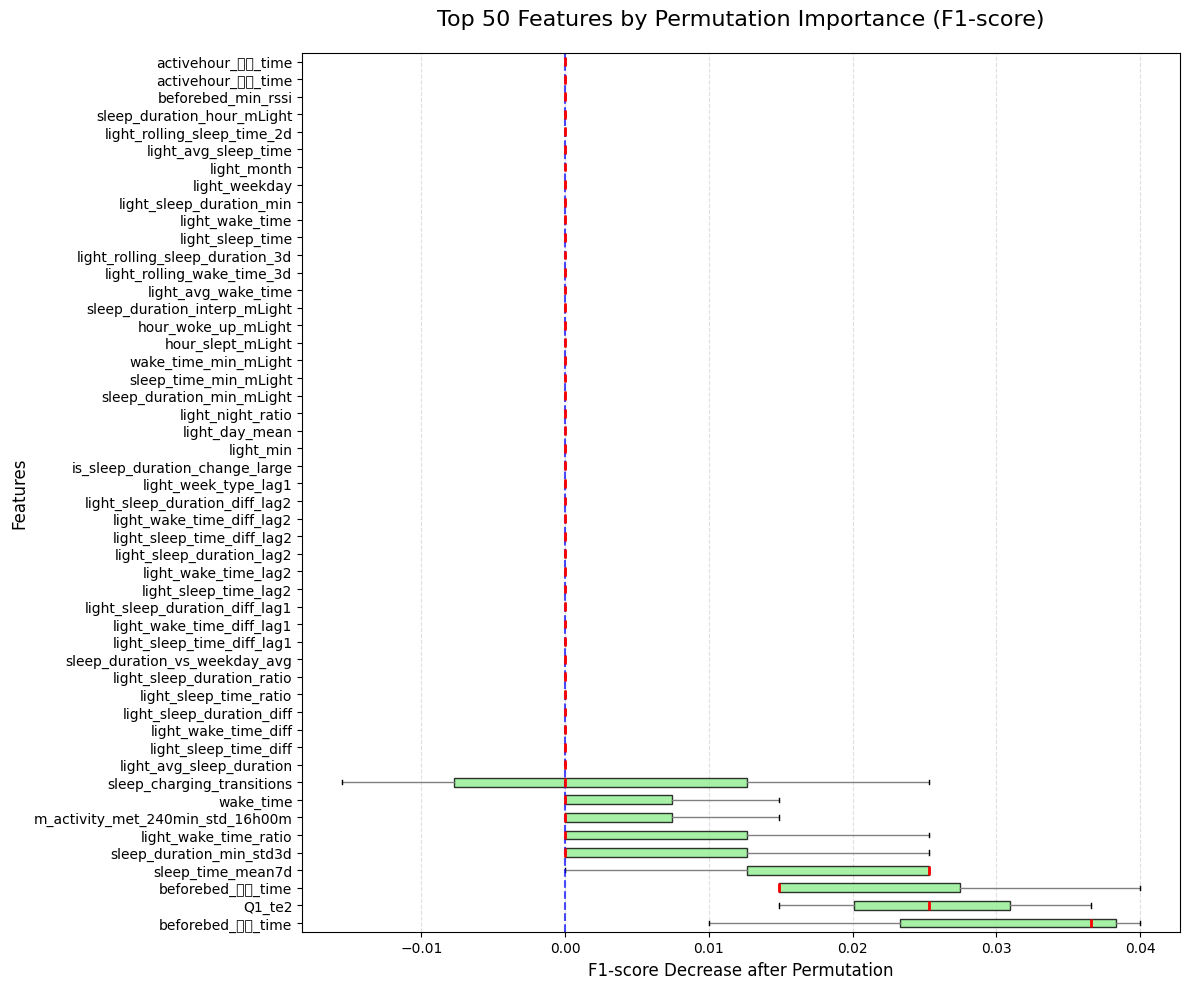

In [ ]:
%%time

# 공통 하이퍼파라미터
common_params = {
  'n_estimators': 5000,
  "learning_rate": 0.01,
  # 'min_data_in_leaf':2,
  # 'bagging_fraction':0.9,
  # 'feature_fraction':0.6,
  'lambda_l1': 5,
  'lambda_l2': 1,
  # 'max_depth': 4,
  'n_jobs': -1,
  'verbosity': -1
}

# 모델별 세부 하이퍼파라미터
best_param_dict = {}
best_param_dict['Q3'] = common_params
best_param_dict['S1'] = common_params
best_param_dict['S2'] = common_params
best_param_dict['S3'] = common_params
best_param_dict['Q1'] = common_params
best_param_dict['Q2'] = common_params

"""
◎ valid   : 0.6492
◎ public  : 0.63775
◎ weights : Rank 1: lgb_A=0.2, xgb_B=0.4, tabpfn_C=0.0, llm_D=0.4

 평균 F1: 0.6468 / [상세] Q1(기상직후수면질):0.7103 Q2(취침전신체적피로):0.7867 Q3(취침전스트레스):0.5833 S2(수면효율):0.5960 S3(수면잠들기시간):0.6931 S1(S1):0.5113
# 전체 평균 F1: 0.6468
================================================

 STEP2: 전체 데이터로 모델 재학습
====== modeling with 100% train & no valid =====
[Q1] Q1_te2(341), wake_time(260), beforebed_통화_time(181), Q1_te(178), mlight_first_wakeup_minutes(173), activehour_통화_time(157), 추정수면효율(155), activehour_total_screen_time(145), lights_off_time(140), sleep_hour_mean_speed(138)
[Q2] Q2_te2(638), activehour_total_screen_time(207), sleep_duration_min_std3d(198), active_hour_std_hr(197), beforebed_unique_bssid_count(196), activehour_screen_time_vs_avg_pct(174), beforebed_max_rssi(173), sleep_duration_vs_weekday_avg(151), wake_time_std7d(146), Q2_te(145)
[Q3] Q3_te2(615), light_max(227), activehour_screen_time_vs_avg_pct(150), beforebed_scan_count(149), m_activity_met_240min_sum_04h00m(143), mlight_first_wakeup_minutes(137), walking_minutes(135), beforebed_메신저_time(128), free_hour_unknown_ratio(125), active_hour_distance_x(121)
[S2] S2_te(1825), S2_te2(279), free_hour_rssi_mean(210), sleep_hour_mean_speed(199), light_sleep_time_lag1(177), sleep_duration_vs_weekday_avg(173), m_activity_240min_std_12h00m(131), activehour_전화_time(126), sleep_duration_lag2(119), work_hour_rssi_mean(115)
[S3] S3_te(1843), S3_te2(230), wake_time_std2d(181), light_night_mean(168), wake_time_ratio_std3d(163), sleep_time_diff_lag2(150), light_rolling_wake_time_2d(125), sleep_time_min_mLight(116), m_activity_240min_std_08h00m(109), wake_time_std5d(108)
[S1] avg_wake_time(1683), S1_te(496), sleep_duration_min(482), S1_te2(438), light_sleep_time_ratio(382), m_activity_met_240min_sum_04h00m(323), wake_time(314), light_sleep_time_diff(300), beforebed_total_screen_time(243), active_hour_burned_calories(234)
# submission_0.6467863583854263.csv 저장 완료
# submission shape:(250, 9)
================================================

Top 10 Weight Combinations:
Rank 1: lgb_A=0.6, xgb_B=0.1, tab_C=0.3 - Score: 0.6571
Saved submission to submission_top1_0.6571.csv
Rank 2: lgb_A=0.3, xgb_B=0.5, tab_C=0.2 - Score: 0.6554
Saved submission to submission_top2_0.6554.csv

 STEP3: 예측결과 비교표
학습sum	학습len	학습mean	테스트sum	테스트len	테스트mean
Q1	223	450	0.4956	131	250	0.5240
Q2	253	450	0.5622	150	250	0.6000
Q3	270	450	0.6000	184	250	0.7360
S1	390	450	0.8667	209	250	0.8360
S2	293	450	0.6511	164	250	0.6560
S3	298	450	0.6622	180	250	0.7200

CPU times: user 35min 20s, sys: 3.18 s, total: 35min 23s
Wall time: 5min 3s
"""

def sanitize_column_names(df):
    df.columns = df.columns.str.replace(r'[^\w]', '_', regex=True)
    return df

train = sanitize_column_names(train)
test = sanitize_column_names(test)

submission_final, oof_result = run_basemodel(train, test, valid_ids, best_param_dict, n_splits=5, n_top_features=50, random_state=41)

### 📦 이전제출과 비교

In [ ]:
from pathlib import Path

# Reference file
reference_file = '/content/drive/MyDrive/data/ch2025_data_items/share/submissions/submission_top1_0.6492.csv'
ref_df = pd.read_csv(reference_file)

# Get all CSV files in data directory
data_dir = Path('./')
csv_files = list(data_dir.glob('*.csv'))

# Store differences for each file
differences = []

for csv_file in csv_files:
    if csv_file.name == os.path.basename(reference_file):
        continue

    # Read current file
    current_df = pd.read_csv(csv_file)

    # Calculate differences in specified columns
    diff_count = 0
    for col in ['Q1', 'Q2', 'Q3', 'S1', 'S2', 'S3']:
        diff_count += (ref_df[col] != current_df[col]).sum()

    differences.append((csv_file.name, diff_count))
    # print(f"File: {csv_file.name}, Differences: {diff_count}")

# Sort by difference count and get top 20
differences.sort(key=lambda x: x[1])
print("\nTop 10 files with smallest differences:")
for i, (file_name, diff_count) in enumerate(differences[:20], 1):
    print(f"{str(i).zfill(2)}. {file_name}: {diff_count} differences")


Top 10 files with smallest differences:
01. submission_top3_0.6546.csv: 152 differences
02. submission_top9_0.6516.csv: 152 differences
03. submission_top2_0.6554.csv: 158 differences
04. submission_top8_0.6517.csv: 158 differences
05. submission_top10_0.6512.csv: 159 differences
06. submission_top7_0.6522.csv: 160 differences
07. submission_top6_0.6531.csv: 161 differences
08. submission_top1_0.6571.csv: 164 differences
09. submission_top5_0.6540.csv: 166 differences
10. submission_top4_0.6540.csv: 167 differences
11. submission_0.6467863583854263.csv: 201 differences
